# Analysis of the HilbertCube1 sweep results

This analysis will:
1- Load the csv results files on the shape comparison of this analysis
2- Compare the error results with the differents metrics

In [1]:
import numpy
import plotly
from pathlib import Path
from tqdm import tqdm
from typing import Tuple
import pyvista as pv
import numpy as np
import plotly.express as px
import pandas as pd

## Variables

In [2]:
DATA_PATH = Path(r"E:\Leopold\Chapitre 6 - AMGNN\Results\Sweep 1 HilbertCube1 shape\test_output")

## List of runs folders

In [3]:
run_folders = DATA_PATH.iterdir()
run_folders = [ f for f in run_folders if f.is_dir()]
run_folders

[WindowsPath('E:/Leopold/Chapitre 6 - AMGNN/Results/Sweep 1 HilbertCube1 shape/test_output/2023_03_20_18_49_simple_gnn_0.7_0.15_0.15lr_1e-03 test_output'),
 WindowsPath('E:/Leopold/Chapitre 6 - AMGNN/Results/Sweep 1 HilbertCube1 shape/test_output/2023_03_21_09_14_simple_gnn_1_0_0lr_1e-03 test_output'),
 WindowsPath('E:/Leopold/Chapitre 6 - AMGNN/Results/Sweep 1 HilbertCube1 shape/test_output/2023_03_21_23_39_double_head_simple_gnn_1_0_0lr_1e-03 test_output'),
 WindowsPath('E:/Leopold/Chapitre 6 - AMGNN/Results/Sweep 1 HilbertCube1 shape/test_output/2023_03_22_14_23_simple_conv_1_0_0lr_1e-03 test_output'),
 WindowsPath('E:/Leopold/Chapitre 6 - AMGNN/Results/Sweep 1 HilbertCube1 shape/test_output/2023_03_23_05_24_double_head_simple_conv_0.7_0.15_0.15lr_1e-03 test_output'),
 WindowsPath('E:/Leopold/Chapitre 6 - AMGNN/Results/Sweep 1 HilbertCube1 shape/test_output/2023_03_23_11_55_simple_conv_0.5_0.25_0.25lr_1e-03 test_output'),
 WindowsPath('E:/Leopold/Chapitre 6 - AMGNN/Results/Sweep 1 H

In [4]:
def extract_results(folder_path: Path, metric_name:str, compute:str = "mean") -> Tuple[float,float]:
    """ Extract the metric results and its stadard deviation from a results folder.
    
    From all vtk files in the folder_path, extract the decired metric and compute its mean (compute) and stadard deviation.
    Args:
        - folder_path: Path to the folder containing all .vtk files
        - metric_name: str of the stored metric in the .vtk files
        - compute: str ("mean") was computation to do to the extracted metrics   
        
    Return:
        - float : the mean (or compute) of the metric
        - float : the stadard deviation of the metric
    """
    # Type check
    folder_path = Path(folder_path)
    metric_name = str(metric_name)
    compute = str(compute)
    
    # Initialise an empty array to store the metric results
    metric_results = []
    
    # List vtk files in the given folder
    vtk_files = list(folder_path.glob("*.vtk"))
    
    if len(vtk_files) == 0:
        raise FileNotFoundError(f"No vtk files found in {folder_path}")
        
    # For each vtk files, read the metric and add it to the metric_results array
    for file in vtk_files:
        vtk = pv.read(file)
        
        # Check that the desired metric exist and add it to the metric_results array
        if metric_name in vtk.array_names:
            metric_results.extend(vtk[metric_name])
        else:
            raise KeyError(f"Key {metric_name} is not present in this vtk files. The available keys are: {vtk.array_names}")
    
    # Compute statistic on the metric_results array 
    if compute == "mean":
        metric = np.mean(metric_results)  
    elif compute == "max":
        metric = np.max(metric_results)
    elif compute == "min":
        metric = np.min(metric_results)
    elif compute == "median":
        metric = np.median(metric_results)
    else:
        raise NotImplemented(f"Compute keywork {compute} not implemented")
        
    std = np.std(metric_results)
    
    return metric, std
    
                     

extract_results(run_folders[0], "L1", "mean")

(0.0045510596, 0.0020865833)

In [5]:
pv.read(list(run_folders[0].glob("*.vtk"))[0]).array_names

['Distances from simulation ray trace (mm)',
 'Normal',
 'Simufact',
 'AMGNN',
 'Difference',
 'MSE',
 'L1',
 'L2',
 'implicit_distance',
 'Distances from simulation (mm)']

## Apply to all runs

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.55it/s]


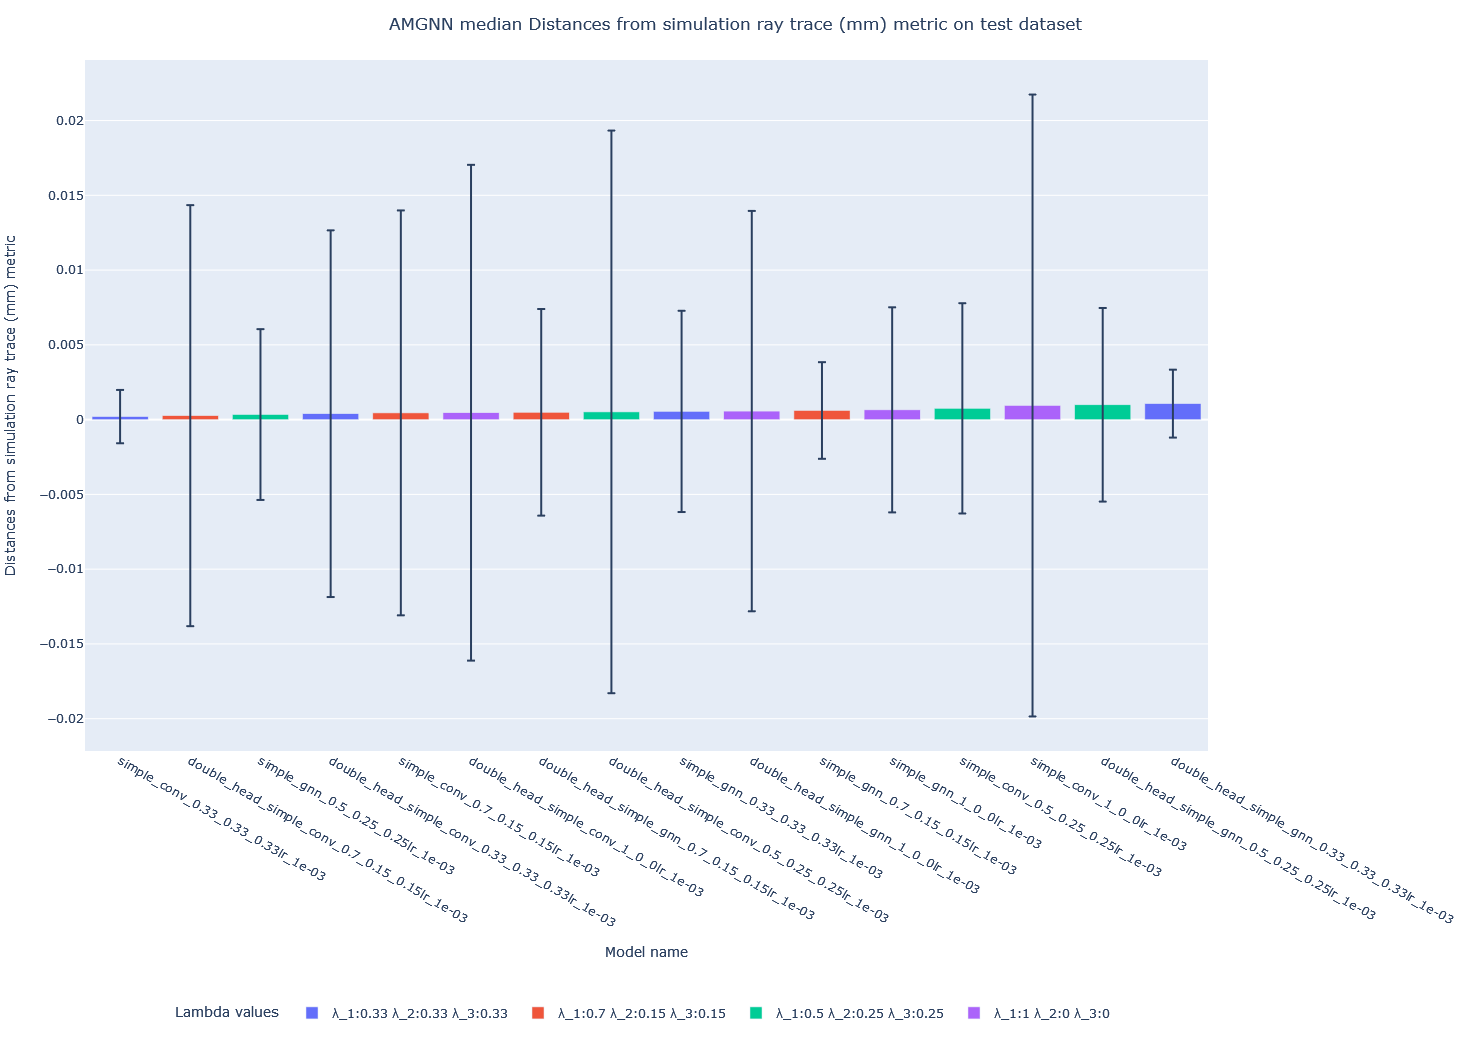

In [15]:
METRIC_NAME = 'Distances from simulation ray trace (mm)'#"Distances from simulation (mm)"
COMPUTE = "median"


def generate_figure(METRIC_NAME, COMPUTE):
    names = []
    metrics = []
    stds = []
    lambdas = []

    for run in tqdm(run_folders):
        name = "_".join(run.name.split(" ")[0].split("_")[5:])
        metric, std = extract_results(run, METRIC_NAME, COMPUTE)

        names.append(name)
        metrics.append(metric)
        stds.append(std)

        # Extract and format lambda parameters from the name
        lamb = name.split("_")[-4:-1]
        lamb[2] = lamb[2].split("lr")[0]
        lamb = f"\u03BB_1:{lamb[0]} \u03BB_2:{lamb[1]} \u03BB_3:{lamb[2]}"
        #r'$\sqrt{(n_\text{c}(t|{T_\text{early}}))}$',
        lambdas.append(lamb)

    data = pd.DataFrame()
    data["name"] = names
    data["metric"] = metrics
    data["std"] = stds
    data["lambdas"] = lambdas
    data = data.sort_values(by=['metric'])
    data.dtypes, data.head()

    fig = px.bar(data, x="name", y="metric", error_y="std", color="lambdas" ,log_y=False,  labels={"lambdas": "Lambda values"})

    fig.update_layout(
        xaxis_title="Model name", yaxis_title=f"{METRIC_NAME} metric"
    )
    fig.update_layout(legend=dict(
        yanchor="bottom",
        y=-0.40,
        orientation = "h",   # show entries horizontally
        xanchor = "center",  # use center of legend as anchor
        x = 0.5))             # put legend in center of x-axis


    fig.update_layout(height=800*1.3, width=1200*1.3, title_text=f"AMGNN {COMPUTE} {METRIC_NAME} metric on test dataset",  title_x=0.5)
    #fig.update_layout(xaxis=dict(autorange="reversed"))
    fig.update_layout(xaxis_categoryorder = 'total ascending')
    fig.show()
    fig.write_image(f"{METRIC_NAME} {COMPUTE} AMGNN results hiltbertcube1.png")
    
generate_figure(METRIC_NAME, COMPUTE)

In [9]:
mets = ['Distances from simulation ray trace (mm)', 'Simufact', 'AMGNN',  'Difference',  'MSE',  'L1',  'L2',  'implicit_distance',  'Distances from simulation (mm)']
computes = ["min", "max", "mean", "median"]

for m in mets:
    for c in computes:
        generate_figure(m,c)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.10it/s]
